In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

# 1. 데이터 준비하기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트 
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 2. 데이터 전처리하기

In [4]:
y= train['price']
del train['price']

* 타겟데이터인 price를 y에 저장하고 train 칼럼에서는 삭제한다

## 학습/테스트 데이터 합쳐서 전처리하기

In [5]:
train_len = len(train)
data=pd.concat((train,test),axis=0)

In [6]:
del data['id']

data['date'] = data['date'].apply(lambda i:i[:6]).astype(int)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


* 필요없는 id 삭제해줌
* 날짜를 '년월' 로만 나타내기(정수형으로 나타냄)

<AxesSubplot:>

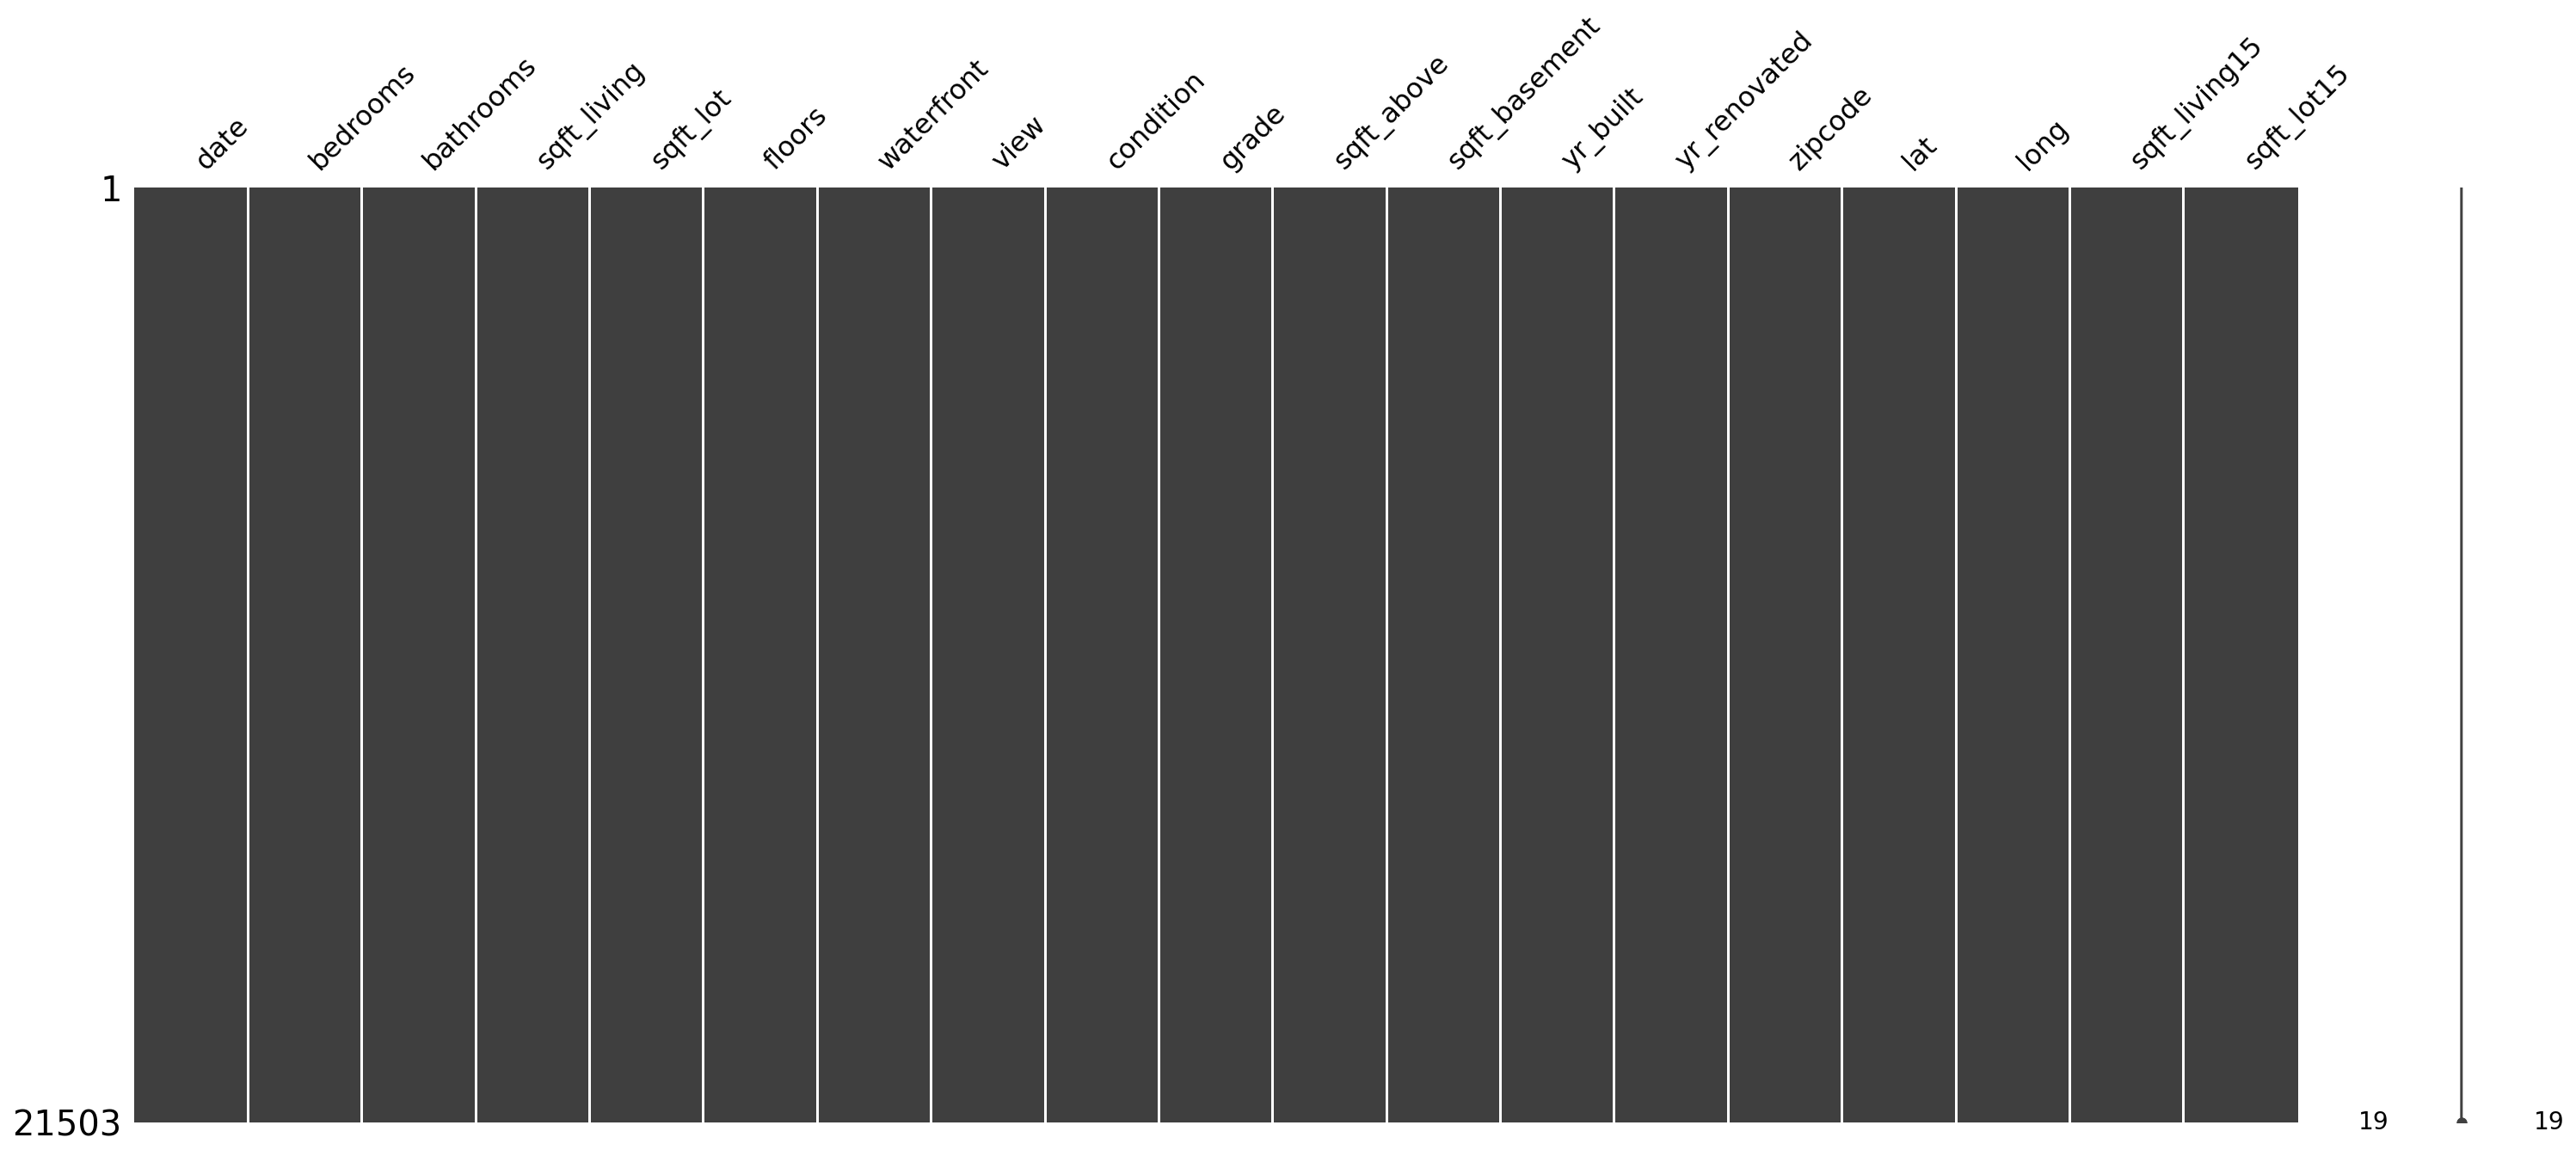

In [7]:
msno.matrix(data)

* 결측치는 없는 것으로 보임

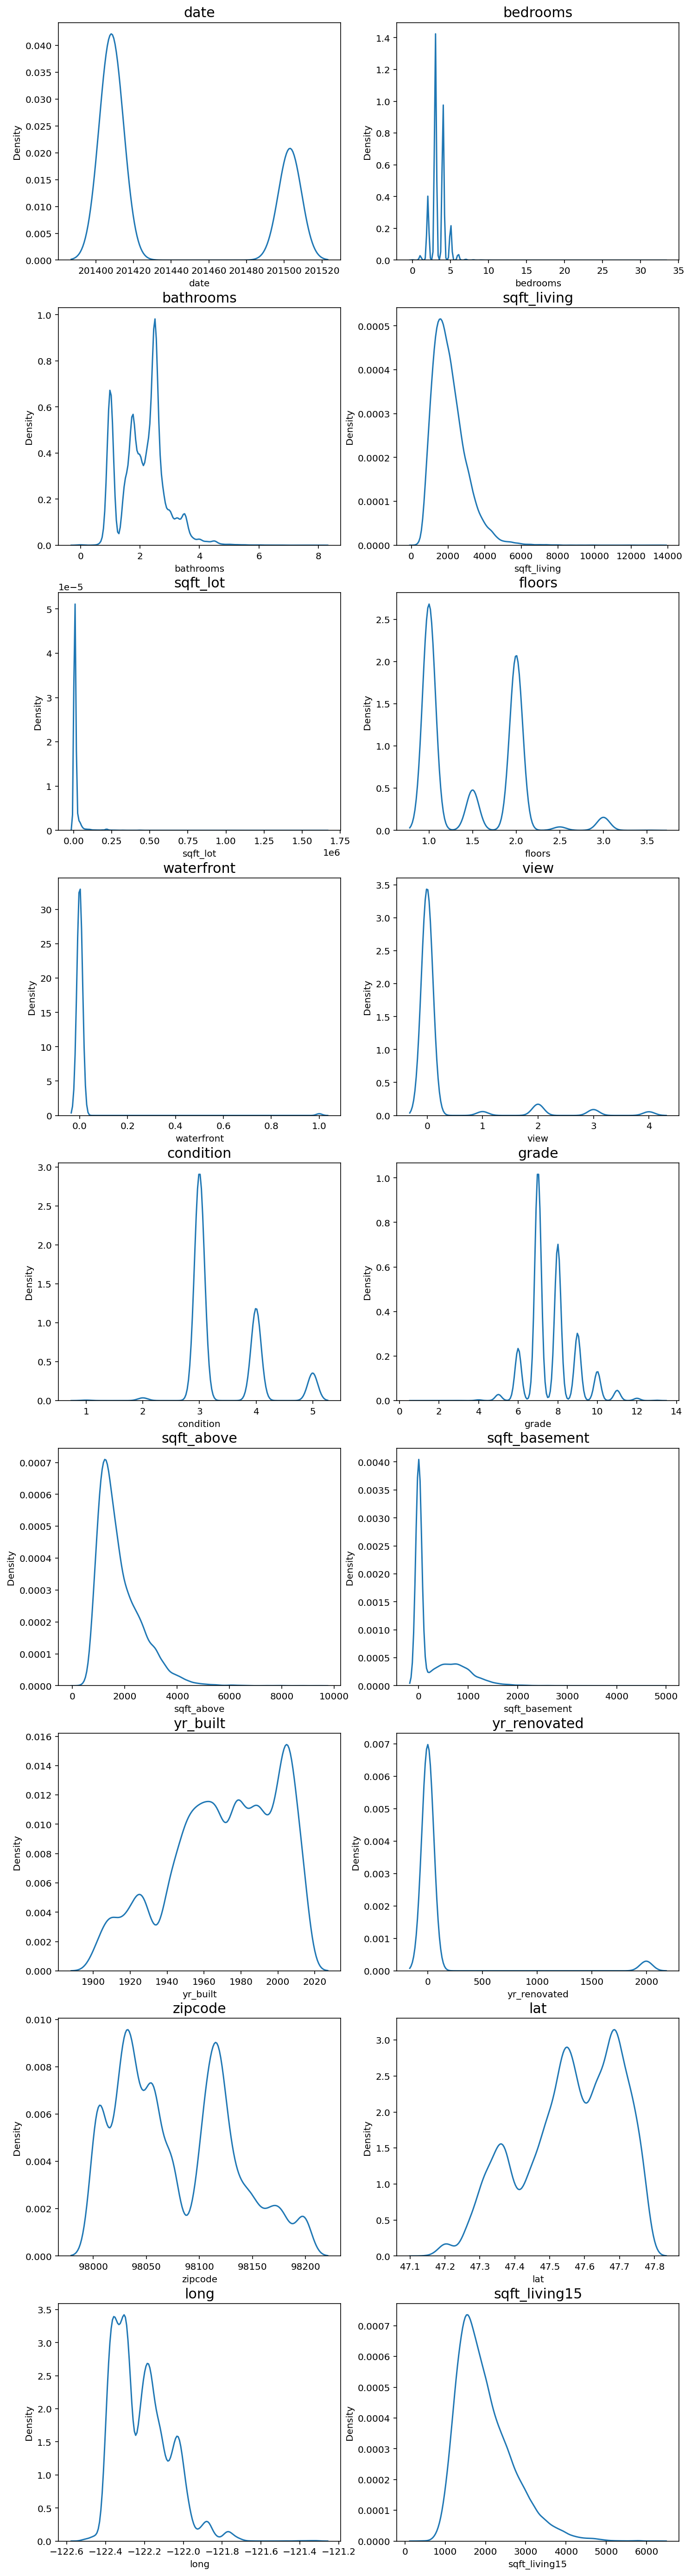

In [8]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))  

count = 0
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

* 각 컬럼의 분포를 살펴보자
* 한쪽으로 치우친 컬럼은 log변환을 통해서 정규분포처럼 맞춰주자 
* 한쪽으로 치우친 컬럼: 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement' ,'sqft_living15','sqft_lot15'

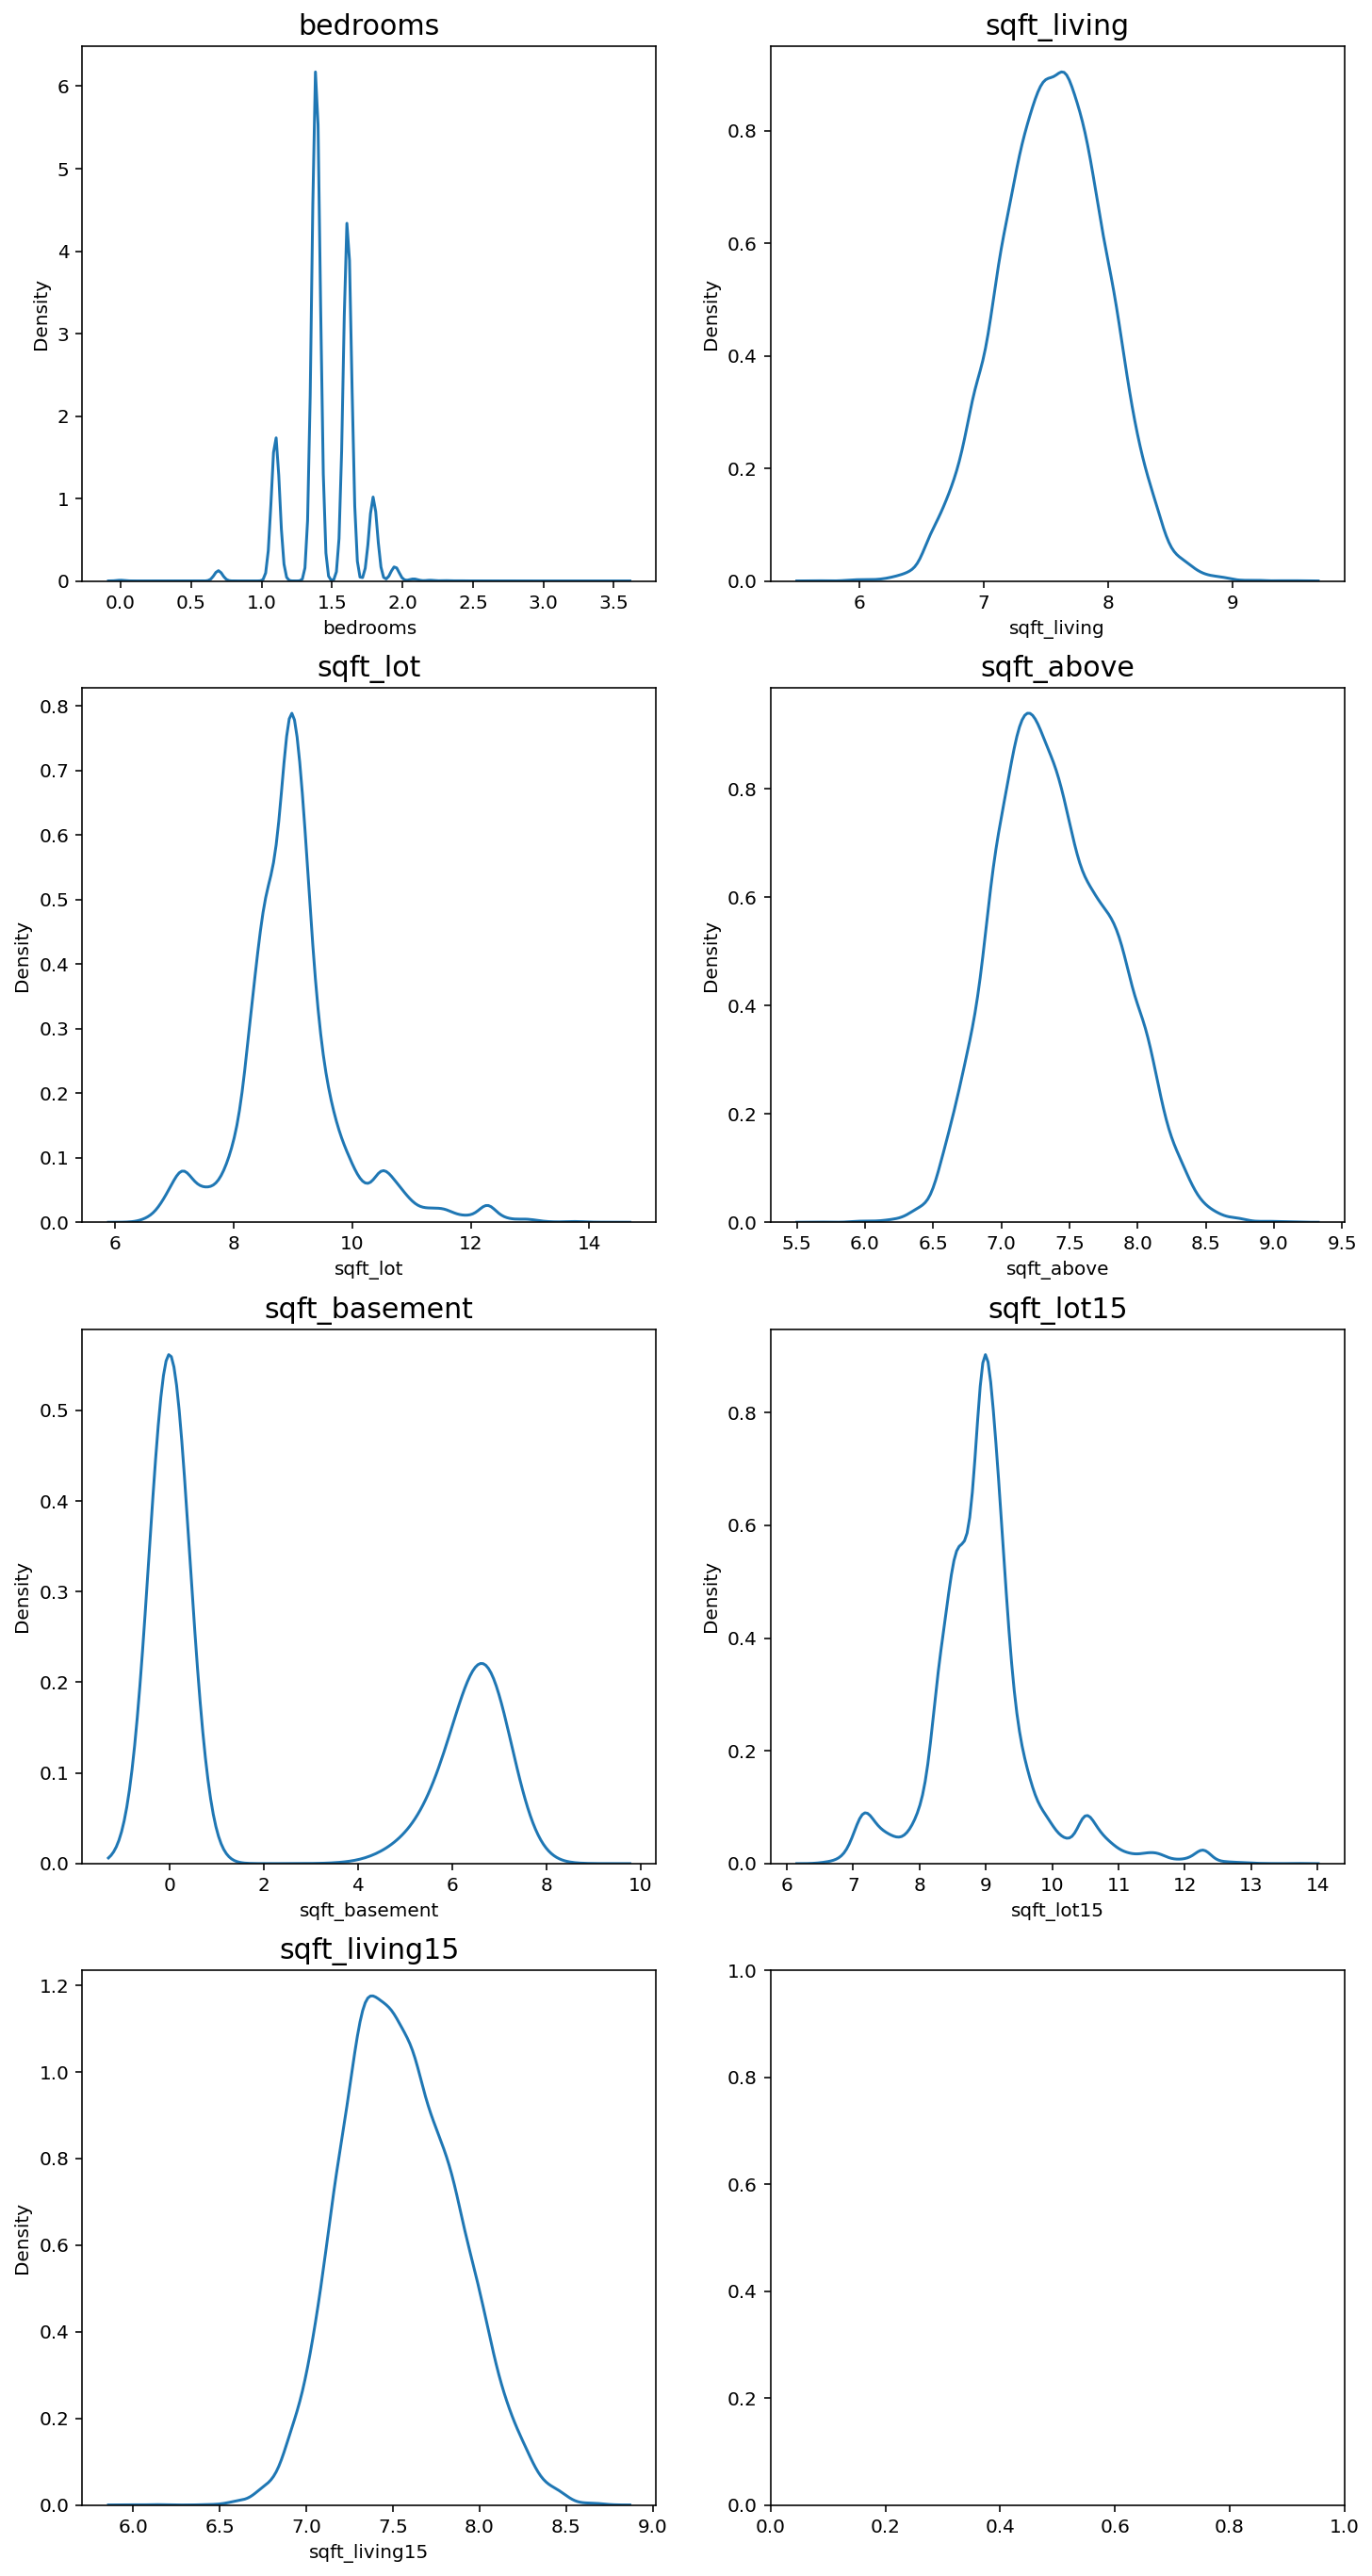

In [9]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1    

* 치우친 분포를 조정했음

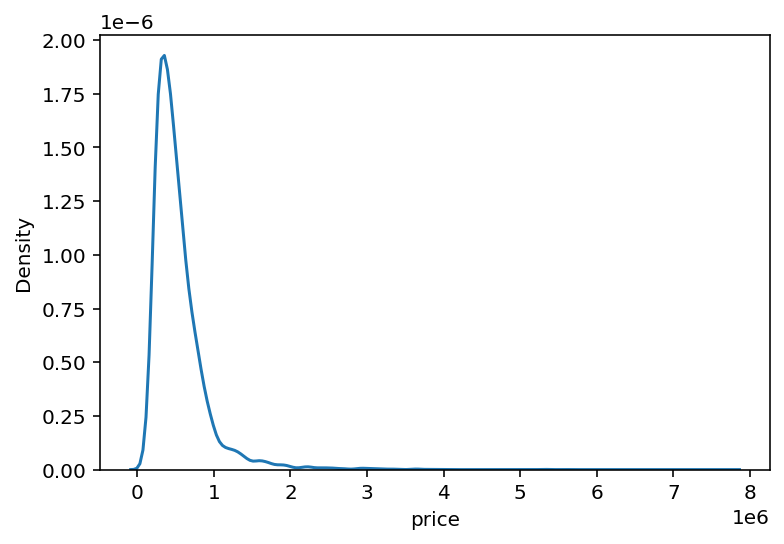

In [10]:
sns.kdeplot(y)
plt.show()

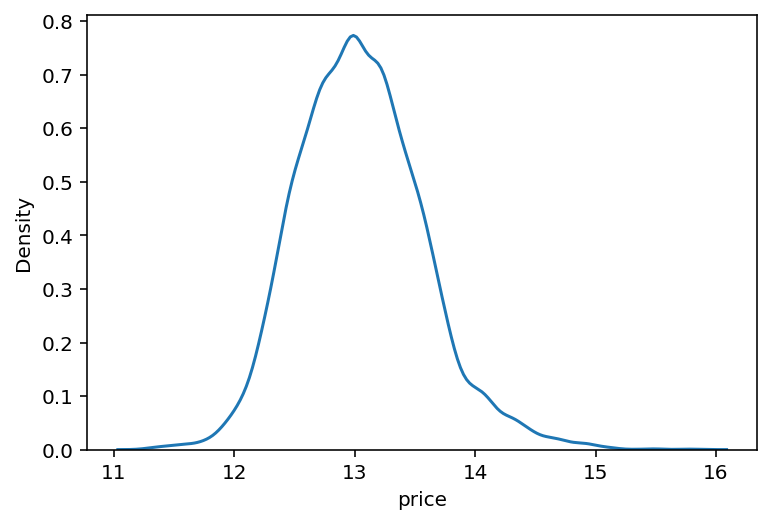

In [11]:
y=np.log1p(y)
sns.kdeplot(y)
plt.show()

* 가격 분포또한 한쪽으로 치우쳐져서 로그 변환 해줬음

## 다시 학습/테스트 데이터 다시 나눠주기

In [12]:
train = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


# 3.모델튜닝을 위한 함수만들기

## 1) 평균제곱근오차 구하는 함수

In [13]:
from sklearn.metrics import mean_squared_error

def rmse(y_test,y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_pred)))

*  평가 척도인 RMSE를 계산하기위해 함수를 만들어줌
* price는 log 로 변환됐기때문에 exp로 다시 돌려준 후 평균제곱근오차를 취해줘야함 


In [14]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

gboost=GradientBoostingRegressor(random_state=2020)
xgboost=XGBRegressor(random_state=2020)
lightgbm=LGBMRegressor(random_state=2020)
rdforest= RandomForestRegressor(random_state=2020)

models=[gboost,xgboost,lightgbm,rdforest]

* 모델 인스턴스를 생성하고 models 라는 리스트에 넣어줌 
* random_state 는 2020으로 고정시켰음

## 2) 모델 각각의 rmse를 구해서 DataFrame을 만드는 함수

In [15]:
from sklearn.model_selection import train_test_split

def get_scores(models,train,y):
    df={}
    for model in models:
        
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # train, test 데이터셋 분리(일종의 validation)
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=2020, test_size=0.2)
        
        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [16]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128370.486911
RandomForestRegressor,125299.591549
LGBMRegressor,111906.268088
XGBRegressor,110319.723794


## 3) 그리드 탐색 함수
### 과정

#### GridSearchCV

* param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
* scoring : 모델의 성능을 평가할 지표
* cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
* verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
* n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid={
    'n_estimstors':[50,100],
    'max_depth':[1,10],
}

model=LGBMRegressor(random_state=2020)

grid_model=GridSearchCV(model,param_grid=param_grid,
                       scoring='neg_mean_squared_error',
                       cv=5, verbose=1, n_jobs=5)

grid_model.fit(train,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Unknown parameter: n_estimstors


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimstors': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

* param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비
* 모델은 LightGBM(lgbm)를 사용
* 하이퍼파라미터 2*2 = 4개의 조합이 나오고 cv를 5번 진행함으로써  totalling 20 fits 나온다.
* 각 조합에 대해 1번만 실험하는것보다 5번 진행해서 평균을 취하는 것이 더 신뢰도가 높다.


In [18]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

results = pd.DataFrame(params)
results['score']=score

results

,max_depth,n_estimstors,score
0,1,50,-0.055024
1,1,100,-0.055024
2,10,50,-0.027024
3,10,100,-0.027024


* 어떤 파라미터 조합일때 어떤 점수가 나오는지가 궁금해
*  파라미터 정보는 params에, 각각에 대한 테스트점수는 mean_test_score에 저장되있음'
* results에 dataframe으로 저장
* 점수가 음수인 이유는 scoring에 neg_mean_squared_error를 넣었기때문이다.

In [19]:
results['RMSE'] = np.sqrt(-1*results['score'])
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values('RMSLE')
results

,max_depth,n_estimstors,score,RMSLE
2,10,50,-0.027024,0.164391
3,10,100,-0.027024,0.164391
0,1,50,-0.055024,0.234571
1,1,100,-0.055024,0.234571


* RMSE 계산해서 추가해줬음
* 데이터 전처리하는 과정에 y값을 log로 변환해줬음 
* 즉, 위에 나타난 RMSE 값은 log를 취한값에서 RMSE를 구한것임

### 3) 최종 그리드 탐색 함수 

In [20]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 훈련
    grid_model.fit(train, y)
    
    #결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

## 4) 제출하는 함수 
### 과정

In [21]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=2020)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164391
2,10,50,-0.029174,0.170804
1,1,100,-0.055024,0.234571
0,1,50,-0.073398,0.270920


* 그리드 탐색으로 하이퍼 파라미터를 정한다.
* 결과 : max_depth=10, n_estimators=100 의 조합이 가장 좋다.

In [22]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=2020)
model.fit(train, y)
prediction = model.predict(test)
prediction=np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

* 가장 좋은 조합으로 모델 훈련을 시킴
* 예측을 하는데 log-> exp로 변환과정이 포함되야한다.

In [23]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [24]:
submission['price']=prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


*  sample submission 데이터프레임에 우리의 모델이 예측한 값을 덮어씌움

In [25]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.165492')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.165492.csv


### 최종 제출하는 함수

In [26]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    
    model.fit(train, y)
    
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

* 모델의 이름과 rmsle값을 넣은 경로를 설정하고 csv 파일로 바꾼후 저장한다.

# 4. 결과

In [27]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.165492')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.165492.csv saved!


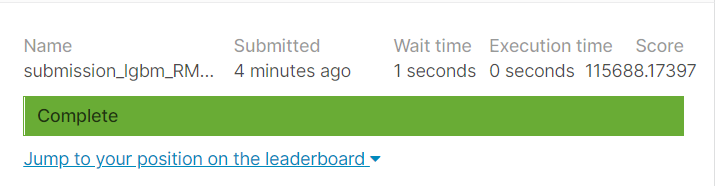

# 5. 랭킹 올려보기

## 1) 하이퍼 파라미터 튜닝하기

In [28]:
param_grid = {
        'n_estimators': [500,700,1000],
    'max_depth': [5,50,100],
    'learning_rate':[0.0001,0.001,0.1]
    
}

model = LGBMRegressor(random_state=2020)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

save_submission(model, train, y, test, 'lgbm', rmsle='5')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_5.csv saved!


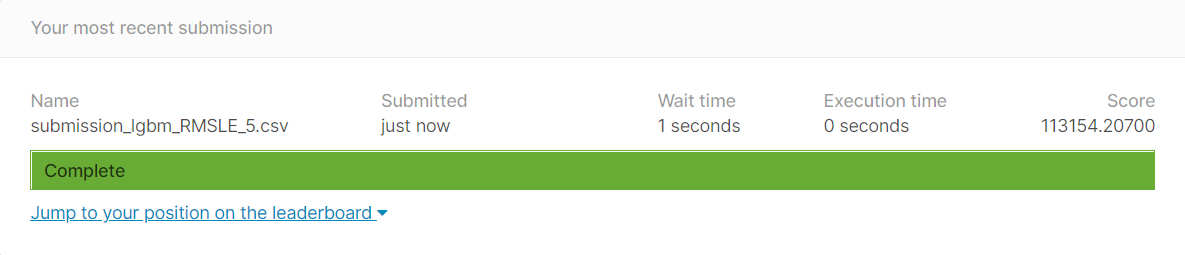

## 2) XGBRegressor 모델 튜닝하기

In [29]:
param_grid = {

    'max_depth': [5,50,100],
    'learning_rate':[0.0001,0.001,0.1]
    
}

model =  XGBRegressor(random_state=2020)

my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

save_submission(model, train, y, test, 'XGB', rmsle='7')

[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.7s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=500; total time=   3.5s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=700; total time=   5.6s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=1000; total time=   9.0s
[CV] END learning_rate=0.0001, max_depth=50, n_estimators=700; total time=   5.3s
[CV] END learning_rate=0.0001, max_depth=50, n_estimators=1000; total time=   6.0s
[C

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=500; total time=   3.1s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=700; total time=   4.4s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=1000; total time=   4.9s
[CV] END learning_rate=0.0001, max_depth=50, n_estimators=500; total time=   3.1s
[CV] END learning_rate=0.0001, max_depth=50, n_estimators=700; total time=   4.6s
[CV] END learning_rate=0.0001, max_depth=50, n_estimators=1000; total time=   6.9s
[CV] END learning_rate=0.0

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=500; total time=   2.3s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=700; total time=   3.9s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=1000; total time=   7.4s
[CV] END learning_rate=0.0001, max_depth=50, n_estimators=500; total time=   3.6s
[CV] END learning_rate=0.0001, max_depth=50, n_estimators=700; total time=   4.9s
[CV

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: n_estimstors
[LightGBM] [Warning] Unknown parameter: n_estimstors
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=500; total time=   2.8s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=700; total time=   3.8s
[CV] END learning_rate=0.0001, max_depth=5, n_estimators=1000; total time=   5.0s
[CV] END learning_rate=0.0001, max_depth=50, n_estimators=500; total time=   4.0s
[CV] END learning_rate=0.0001, max_depth=50, n_estimators=700; total time=   5.5s
[CV] END learning_rate=0.0001, max_depth=50, n_estimators=1000; total time=   8.3s
[CV] END learning_rate=0.0001, max_depth=100, n_estimators=500; total time=   3

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_7.csv saved!


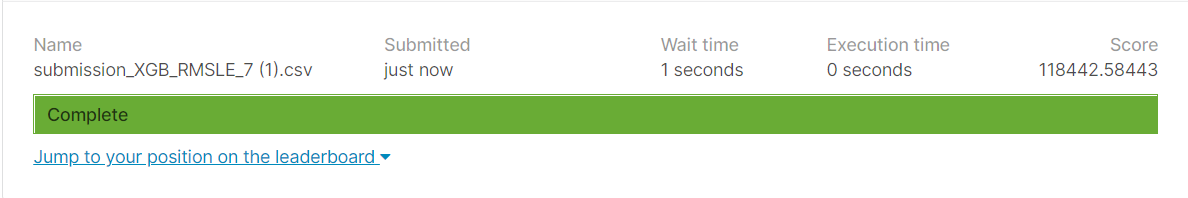

In [31]:
model =  XGBRegressor(n_estimators=1000,max_depth=5,tree_method='hist',learning_rate=0.1,random_state=2020)


save_submission(model, train, y, test, 'XGB', rmsle='8')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_8.csv saved!


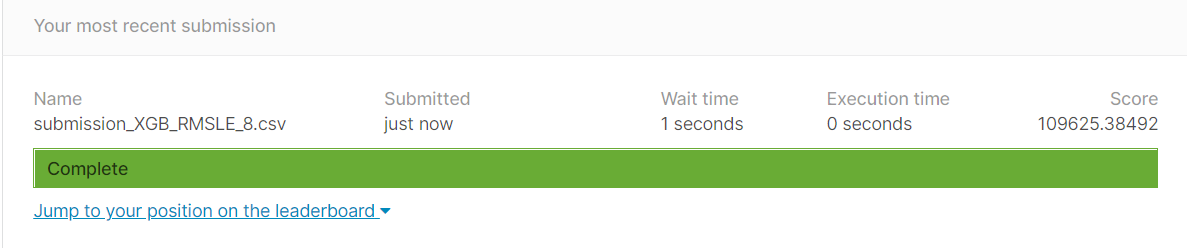

# 회고
## 1. 노드 진행하면서 가진 의문

* concat : axis=0 이면 위아래로 합치는거,axis=1이면 좌우로 합치는것임


* get_scores() 함수 : 훈련용 데이터를 기반으로 하는데 왜 갑자기 train_test_split를 왜 쓰는지 궁금했다. 노드할때 train,validation,test로 나눴던게 생각이 났는데 조원분도 validation 이라고 생각하면 될거같다고해서 생각이 정리됐다.


* 그리드 탐색 : xgboost 관련 하이퍼파라미터를 쓰면서 모델은 lightbg을 써도 되는가? 찾아보니 우리가 쓰는 모델 전부 n_estimstors,max_depth 라는 하이퍼파라미터가 존재했다. 근데 왜 노드에서는 xgboost 관련 하이퍼 파라미터라고만 콕 찝어서 얘기했을까...?헷갈리게


* 하이퍼 파라미터 조합 : 생각을 안해보고 score가 높을수록 좋듯이 rmse 값도 높을수록 좋다고 생각했다. 근데 rmse는 오차에 관련된 내용이니 당연히 오차가 작을수록 좋은것이다.


## 2. 랭킹을 올리기위해 시도한것

* lgbm 모델의 하이퍼파라미터 조절을 그리드서치로 계속 시도했으나 점수는 낮아지지않았다.


* XGBRegressor() 그리드서치를 사용해서 엄청난 시간을 기다렸는데 lgbm 보다 더 높은 점수였다.하이퍼파라미터를 더 넣어줘야할것같은데 또 기다리자니 시간이 너무 오래걸릴거같았다.


* 그래서 그리드서치 대신에 일일이 하이퍼파라미터를 조절했다. 훨씬 빠르게 결과가 나오고 몇번 시도를 안했는데 11만점 이하로 내려갔다!!


* 하이퍼파라미터 참고 : https://psystat.tistory.com/131,https://ssoonidev.tistory.com/106

